In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np

# Unzipping the dataset
zip_file_path = '/content/drive/MyDrive/Medicinal Leaf Dataset.zip'  # Adjust the path
destination_folder = '/content/dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# Set up the directories for train, test, and validation
base_dir = '/content/leaf_dataset_split'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

# Create train, test, validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# List of classes (folder names)
class_folders = os.listdir(destination_folder)

# Split data and copy into train, test, and validation folders
for class_folder in class_folders:
    class_path = os.path.join(destination_folder, class_folder)

    # Get all image file paths in the class folder
    image_files = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]

    # Split into train (70%), test (15%), validation (15%)
    train_images, test_images = train_test_split(image_files, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

    # Copy the images to their respective directories
    def copy_images(image_list, target_folder):
        class_folder_path = os.path.join(target_folder, class_folder)
        os.makedirs(class_folder_path, exist_ok=True)
        for image_path in image_list:
            shutil.copy(image_path, class_folder_path)

    copy_images(train_images, train_dir)
    copy_images(test_images, test_dir)
    copy_images(val_images, validation_dir)

# Set up data augmentation to increase image count
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images and save them
def augment_images(input_folder, output_folder, num_augmented_images):
    for class_name in os.listdir(input_folder):
        class_folder_path = os.path.join(input_folder, class_name)
        output_class_folder = os.path.join(output_folder, class_name)
        os.makedirs(output_class_folder, exist_ok=True)

        for img_name in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, img_name)
            img = Image.open(img_path)
            img = img.resize((150, 150))  # Resize if needed
            img_array = np.expand_dims(np.array(img), 0)

            # Augment and save images
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_class_folder,
                                      save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= num_augmented_images:
                    break

# Apply augmentation to the train set
augment_images(train_dir, train_dir, num_augmented_images=5)

# Zip the augmented dataset (train, test, validation)
output_zip_path = '/content/leaf_dataset_split_augmented.zip'
shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', base_dir)

# Move the zip file to Google Drive (optional)
shutil.move(output_zip_path, '/content/drive/MyDrive/leaf_dataset_split_augmented.zip')

print("Dataset split and augmentation complete, zip file saved to Google Drive.")


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
import os
import zipfile

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/plant recognition/medicinal_plant.zip'  # Adjust the path to match your zip file location

# Destination folder to unzip the contents
destination_folder = '/content'

# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

In [ ]:
!pip install tensorflow keras numpy matplotlib

In [ ]:
!pip uninstall jax jaxlib -y
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

Found existing installation: jax 0.4.33
Uninstalling jax-0.4.33:
  Successfully uninstalled jax-0.4.33
Found existing installation: jaxlib 0.4.33
Uninstalling jaxlib-0.4.33:
  Successfully uninstalled jaxlib-0.4.33


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory where your dataset is stored
dataset_dir = '/content/Medicinal plant dataset'

# Define data augmentation parameters for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,  # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Apply random shear transformations
    zoom_range=0.2,  # Randomly zoom into images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Fill in missing pixels after rotation or shift
    validation_split=0.2  # Use 20% of the data for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use 80% for training
)

# Validation data generator (no augmentation)
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use 20% for validation
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Here you can also specify validation_split to create a separate test generator if needed
# For this example, we will assume you can use the same dataset without separate directory
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data for consistent evaluation
)


Found 4765 images belonging to 40 classes.
Found 1180 images belonging to 40 classes.
Found 5945 images belonging to 40 classes.


In [ ]:
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

['Aloevera', 'Amla', 'Amruta_Balli', 'Arali', 'Ashoka', 'Ashwagandha', 'Avacado', 'Bamboo', 'Basale', 'Betel', 'Betel_Nut', 'Brahmi', 'Castor', 'Curry_Leaf', 'Doddapatre', 'Ekka', 'Ganike', 'Gauva', 'Geranium', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jasmine', 'Lemon', 'Lemon_grass', 'Mango', 'Mint', 'Nagadali', 'Neem', 'Nithyapushpa', 'Nooni', 'Pappaya', 'Pepper', 'Pomegranate', 'Raktachandini', 'Rose', 'Sapota', 'Tulasi', 'Wood_sorel']


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# Load the pre-trained MobileNet model, excluding the top layers
base_model = MobileNet(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Create a new model with MobileNet as the base
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replaces Flatten layer to reduce dimensions
    Dense(512, activation='relu'),  # Add custom dense layer
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer based on number of classes
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

# Save the model
model.save('/content/drive/MyDrive/plant recognition/M_plant_recognition_model_mobilenet.h5')


<ipython-input-8-66e2edf7ebf5>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 58s 352ms/step - accuracy: 0.1912 - loss: 3.3783 - val_accuracy: 0.6127 - val_loss: 1.4771
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 70s 287ms/step - accuracy: 0.5151 - loss: 1.6713 - val_accuracy: 0.7017 - val_loss: 1.0391
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 83s 291ms/step - accuracy: 0.6319 - loss: 1.2454 - val_accuracy: 0.7254 - val_loss: 0.9172
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.6947 - loss: 1.0416 - val_accuracy: 0.7729 - val_loss: 0.7374
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 46s 297ms/step - accuracy: 0.6930 - loss: 0.9684 - val_accuracy: 0.8051 - val_loss: 0.7012
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 81s 288ms/step - accuracy: 0.7248 - loss: 0.9144 - val_accuracy: 0.8169 - val_loss: 0.6317
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 44s 289ms/step - accuracy: 0.7502 - loss: 0.8293 - val_accuracy: 0.8127 - val_loss: 0.6391
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 81s 282ms/step - accuracy: 0.7574 - loss: 0

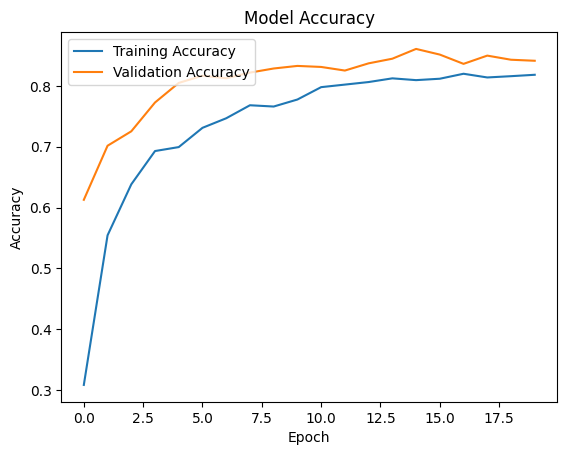

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()



In [ ]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/plant recognition/M_plant_recognition_model_mobilenet.h5')
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to preprocess the image
def preprocess_image(img_path):
    # Load the image with target size 150x150
    img = image.load_img(img_path, target_size=(150, 150))

    # Convert the image to array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the model's input shape (batch size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image (rescale pixel values as done during training)
    img_array /= 255.0

    return img_array
# Path to the sample image
img_path = '/content/Medicinal plant dataset/Arali/355.jpg'

# Preprocess the image
preprocessed_img = preprocess_image(img_path)

# Predict the class
predictions = model.predict(preprocessed_img)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the corresponding class label
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted class: {predicted_class_label}")


ValueError: Layer "dense_2" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 4, 4, 1024), dtype=float32, sparse=False, name=keras_tensor_359>, <KerasTensor shape=(None, 4, 4, 1024), dtype=float32, sparse=False, name=keras_tensor_360>]